In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-05-18 15:43:00.542624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 15:43:00.620225: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 15:43:00.979699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-05-18 15:43:00.979739: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12286
12286
12286
12286
12286
12286
12286
12286


In [7]:
######################
# ONLY HITS_top DATA #
######################

# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000



hits_top_B = np.array( f_B['HITS_top_img/ev_1'] )
hits_top_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    

# close the h5 files
f_B.close()
f_S.close()



# X and Y for the classifier
X_mon = np.row_stack([hits_top_B,hits_top_S])
# normalize
#X_mon = scaler.fit_transform(X_mon)
X_mon = np.reshape(X_mon, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (9999, 128, 128, 1)
y_mon_train :  (9999,)
X_mon_val :  (3334, 128, 128, 1)
y_mon_val :  (3334,)
X_mon_test :  (6667, 128, 128, 1)
y_mon_test :  (6667,)



### CLASSIFIER

In [8]:
from keras import backend as K
np.random.seed(0)

# Define recall, precision and f1 functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 1 conv layer

In [28]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (X_mon_train.shape[1], X_mon_train.shape[2], X_mon_train.shape[3])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(X_mon_train, y_mon_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_mon_val, y_mon_val))
    model.save('model_save_name.h5')
    #model.save_weights('final_weights.h5')
    score = model.evaluate(X_mon_val, y_mon_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
100/100 [==============================] - 36s 334ms/step - loss: 1.3963 - acc: 0.5601 - f1_m: 0.5188 - precision_m: 0.5745 - recall_m: 0.5193 - val_loss: 0.6681 - val_acc: 0.7993 - val_f1_m: 0.8000 - val_precision_m: 0.7976 - val_recall_m: 0.8071
Epoch 2/50
100/100 [==============================] - 32s 318ms/step - loss: 0.6412 - acc: 0.7228 - f1_m: 0.7286 - precision_m: 0.7206 - recall_m: 0.7515 - val_loss: 0.5700 - val_acc: 0.7903 - val_f1_m: 0.7720 - val_precision_m: 0.8410 - val_recall_m: 0.7170
Epoch 3/50
100/100 [==============================] - 32s 318ms/step - loss: 0.5949 - acc: 0.7529 - f1_m: 0.7560 - precision_m: 0.7486 - recall_m: 0.7767 - val_loss: 0.5170 - val_acc: 0.7984 - val_f1_m: 0.8027 - val_precision_m: 0.7831 - val_recall_m: 0.8280
Epoch 4/50
100/100 [==============================] - 37s 371ms/step - loss: 0.5816 - acc: 0.7562 - f1_m: 0.7578 - precision_m: 0.7558 - recall_m: 0.7714 - val_loss: 0.4992 - val_acc: 0.7987 - val_f1_m: 0.8011 - val_precisi

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 125, 125, 16)      0         
                                                                 
 flatten_5 (Flatten)         (None, 250000)            0         
                                                                 
 dense_10 (Dense)            (None, 32)                8000032   
                                                      

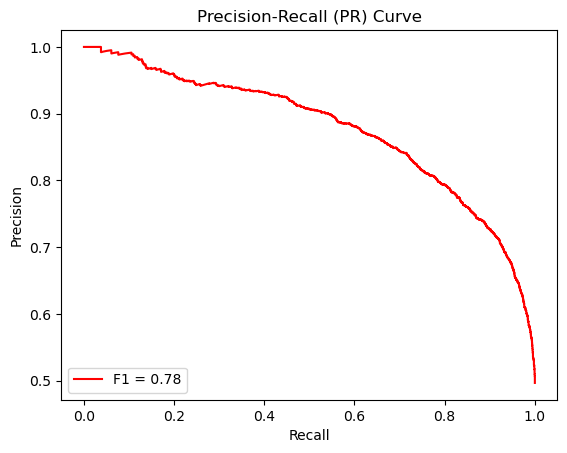

Accuracy: 0.7922603869806509
Average precision: 0.7348562984253579
recall: 0.7589123867069486
AUC:0.8445952306900877
Predicted   0.0   1.0
Actual               
0.0        2770   587
1.0         798  2512


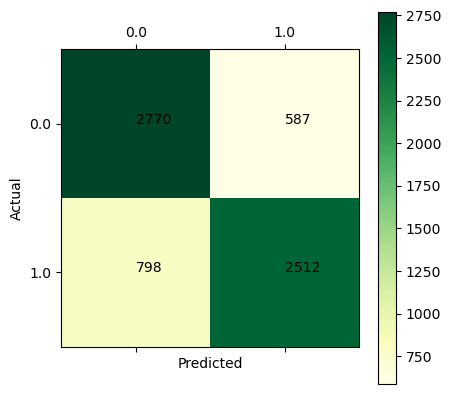

In [29]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model('model_save_name.h5', custom_objects=dependencies)

model.summary()



score = model.evaluate(X_mon_test, y_mon_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict(X_mon_test)    # Predict probabilities
yhat = model.predict(X_mon_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_mon_test, lr_probs)
lr_f1, lr_auc = f1_score(y_mon_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_mon_test[y_mon_test==1]) / len(y_mon_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_mon_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_mon_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_mon_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_mon_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_mon_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

209/209 [==============================] - 5s 25ms/step


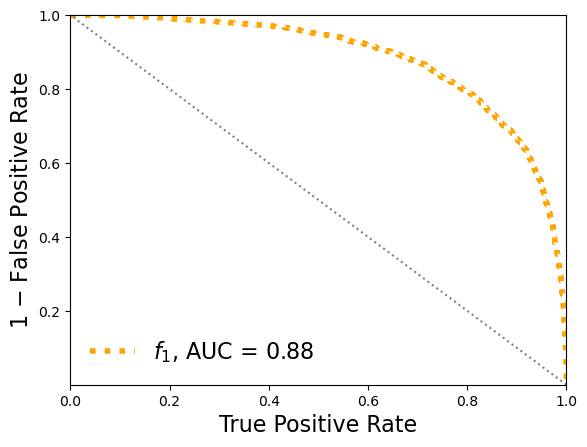

In [30]:

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score

#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'CNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_CNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_CNN = dict()
tpr_CNN = dict()
roc_auc_CNN = dict()
fpr_CNN, tpr_CNN, _ = roc_curve(y_mon_test, y_pred_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)


plt.figure()
plt.plot(tpr_CNN,1-fpr_CNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_CNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [31]:
roc_auc_CNN

0.8816822313837614

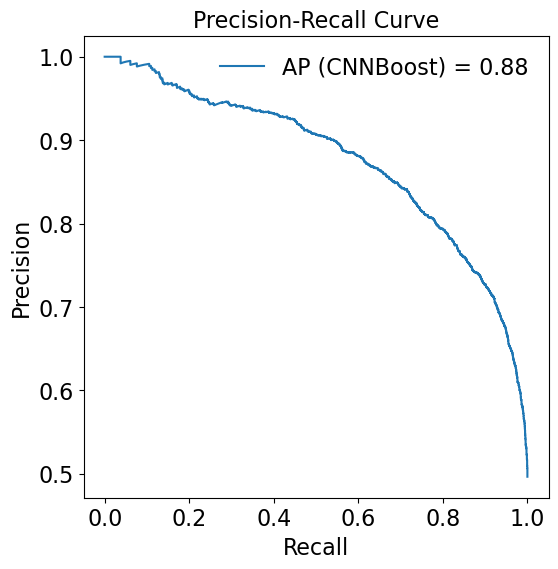

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_CNN, recall_CNN, _ = precision_recall_curve(y_mon_test, y_pred_CNN)
auc_CNN = auc(recall_CNN, precision_CNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_CNN, precision_CNN, label=f'AP (CNNBoost) = {auc_CNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [33]:
auc_CNN

0.8763720017591107

209/209 [==============================] - 5s 25ms/step
Classification score:


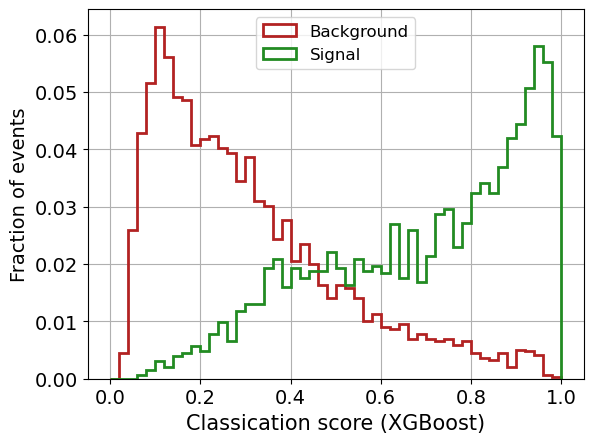

In [34]:
yhat = model.predict(X_mon_test) 

# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_CNN[i,0])
    else:
        pred_XG_NP.append(y_pred_CNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 2 conv layer

In [35]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (X_mon_train.shape[1], X_mon_train.shape[2], X_mon_train.shape[3])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(X_mon_train, y_mon_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_mon_val, y_mon_val))
    model.save('model_save_name.h5')
    #model.save_weights('final_weights.h5')
    score = model.evaluate(X_mon_val, y_mon_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
100/100 [==============================] - 28s 273ms/step - loss: 0.9377 - acc: 0.5995 - f1_m: 0.5371 - precision_m: 0.6158 - recall_m: 0.5515 - val_loss: 0.6765 - val_acc: 0.7645 - val_f1_m: 0.7258 - val_precision_m: 0.8651 - val_recall_m: 0.6290
Epoch 2/50
100/100 [==============================] - 27s 269ms/step - loss: 0.6397 - acc: 0.7543 - f1_m: 0.7416 - precision_m: 0.7835 - recall_m: 0.7201 - val_loss: 0.5627 - val_acc: 0.7942 - val_f1_m: 0.7804 - val_precision_m: 0.8346 - val_recall_m: 0.7360
Epoch 3/50
100/100 [==============================] - 28s 276ms/step - loss: 0.5908 - acc: 0.7828 - f1_m: 0.7752 - precision_m: 0.8068 - recall_m: 0.7553 - val_loss: 0.5521 - val_acc: 0.7969 - val_f1_m: 0.8089 - val_precision_m: 0.7611 - val_recall_m: 0.8672
Epoch 4/50
100/100 [==============================] - 27s 271ms/step - loss: 0.5752 - acc: 0.7822 - f1_m: 0.7760 - precision_m: 0.8009 - recall_m: 0.7618 - val_loss: 0.5373 - val_acc: 0.8008 - val_f1_m: 0.8090 - val_precisi

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 123, 123, 16)      2320      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 123, 123, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 16)       0         
 g2D)                                                 

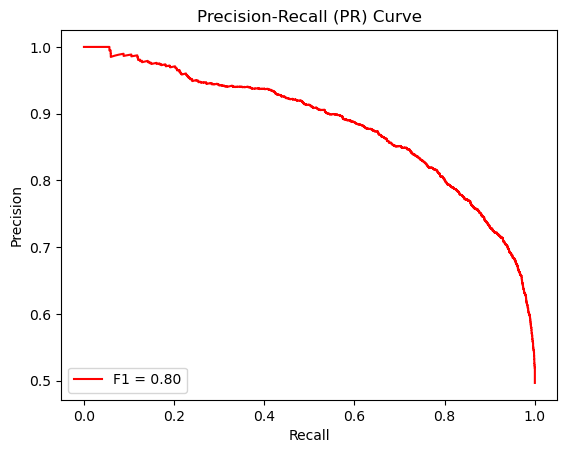

Accuracy: 0.8005099745012749
Average precision: 0.7372488377204445
recall: 0.8051359516616314
AUC:0.848701751231598
Predicted   0.0   1.0
Actual               
0.0        2672   685
1.0         645  2665


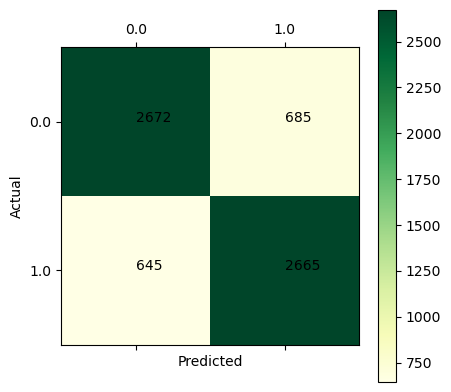

In [36]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model('model_save_name.h5', custom_objects=dependencies)

model.summary()



score = model.evaluate(X_mon_test, y_mon_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict(X_mon_test)    # Predict probabilities
yhat = model.predict(X_mon_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_mon_test, lr_probs)
lr_f1, lr_auc = f1_score(y_mon_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_mon_test[y_mon_test==1]) / len(y_mon_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_mon_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_mon_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_mon_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_mon_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_mon_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

209/209 [==============================] - 3s 13ms/step


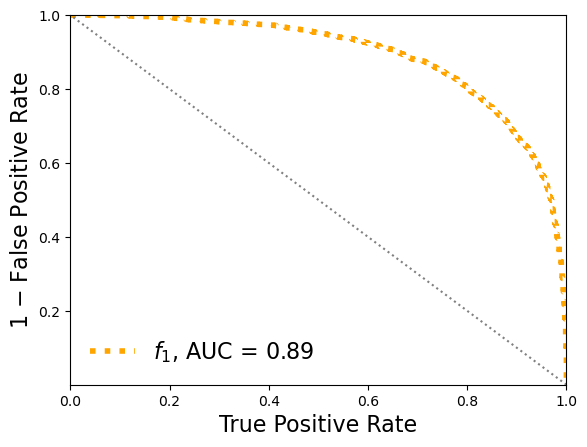

In [37]:

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score

#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'CNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_CNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_CNN = dict()
tpr_CNN = dict()
roc_auc_CNN = dict()
fpr_CNN, tpr_CNN, _ = roc_curve(y_mon_test, y_pred_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)


plt.figure()
plt.plot(tpr_CNN,1-fpr_CNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_CNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [38]:
roc_auc_CNN

0.8888082079471402

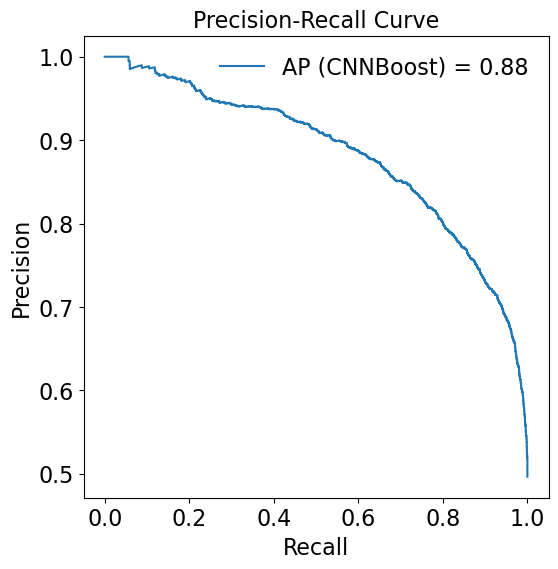

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_CNN, recall_CNN, _ = precision_recall_curve(y_mon_test, y_pred_CNN)
auc_CNN = auc(recall_CNN, precision_CNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_CNN, precision_CNN, label=f'AP (CNNBoost) = {auc_CNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [40]:
auc_CNN

0.8826715988128186

209/209 [==============================] - 3s 13ms/step
Classification score:


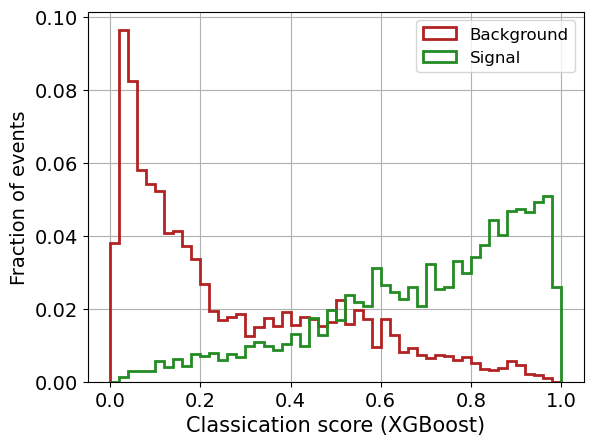

In [41]:
yhat = model.predict(X_mon_test) 

# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_CNN[i,0])
    else:
        pred_XG_NP.append(y_pred_CNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 3 conv layer

In [19]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (X_mon_train.shape[1], X_mon_train.shape[2], X_mon_train.shape[3])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(X_mon_train, y_mon_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_mon_val, y_mon_val))
    model.save('model_save_name.h5')
    #model.save_weights('final_weights.h5')
    score = model.evaluate(X_mon_val, y_mon_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
100/100 [==============================] - 28s 266ms/step - loss: 0.7396 - acc: 0.6673 - f1_m: 0.6566 - precision_m: 0.6863 - recall_m: 0.6745 - val_loss: 0.5852 - val_acc: 0.7915 - val_f1_m: 0.8111 - val_precision_m: 0.7379 - val_recall_m: 0.9047
Epoch 2/50
100/100 [==============================] - 26s 260ms/step - loss: 0.5678 - acc: 0.7840 - f1_m: 0.7768 - precision_m: 0.8018 - recall_m: 0.7644 - val_loss: 0.5285 - val_acc: 0.7957 - val_f1_m: 0.8050 - val_precision_m: 0.7667 - val_recall_m: 0.8517
Epoch 3/50
100/100 [==============================] - 26s 260ms/step - loss: 0.5427 - acc: 0.7849 - f1_m: 0.7789 - precision_m: 0.8003 - recall_m: 0.7662 - val_loss: 0.5046 - val_acc: 0.8002 - val_f1_m: 0.8043 - val_precision_m: 0.7876 - val_recall_m: 0.8254
Epoch 4/50
100/100 [==============================] - 26s 260ms/step - loss: 0.5330 - acc: 0.7883 - f1_m: 0.7832 - precision_m: 0.8001 - recall_m: 0.7753 - val_loss: 0.5116 - val_acc: 0.7978 - val_f1_m: 0.8003 - val_precisi

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 123, 123, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                  

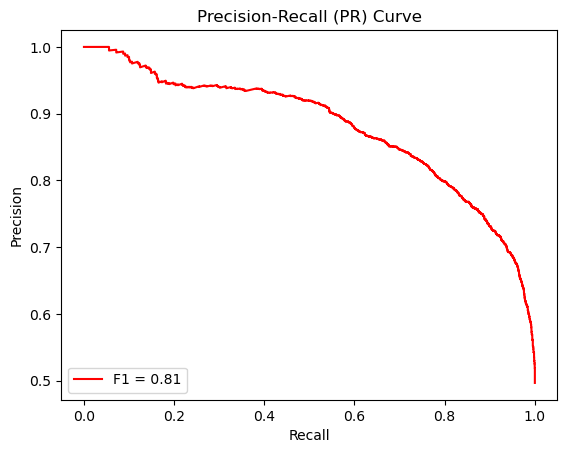

Accuracy: 0.7993100344982751
Average precision: 0.7305517208285742
recall: 0.8377643504531722
AUC:0.8470958442857185
Predicted   0.0   1.0
Actual               
0.0        2556   801
1.0         537  2773


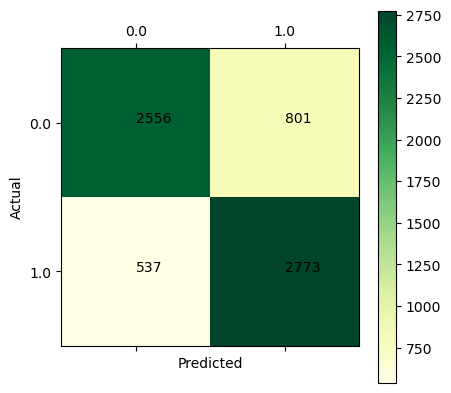

In [20]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model('model_save_name.h5', custom_objects=dependencies)

model.summary()



score = model.evaluate(X_mon_test, y_mon_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict(X_mon_test)    # Predict probabilities
yhat = model.predict(X_mon_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_mon_test, lr_probs)
lr_f1, lr_auc = f1_score(y_mon_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_mon_test[y_mon_test==1]) / len(y_mon_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_mon_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_mon_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_mon_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_mon_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_mon_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

209/209 [==============================] - 3s 14ms/step


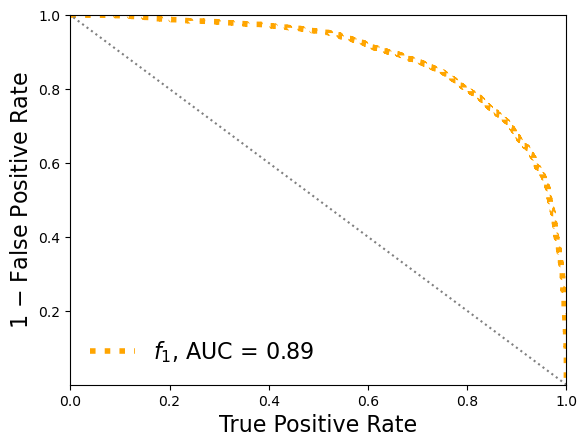

In [21]:

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score

#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'CNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_CNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_CNN = dict()
tpr_CNN = dict()
roc_auc_CNN = dict()
fpr_CNN, tpr_CNN, _ = roc_curve(y_mon_test, y_pred_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)


plt.figure()
plt.plot(tpr_CNN,1-fpr_CNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_CNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [23]:
roc_auc_CNN

0.8868737102523743

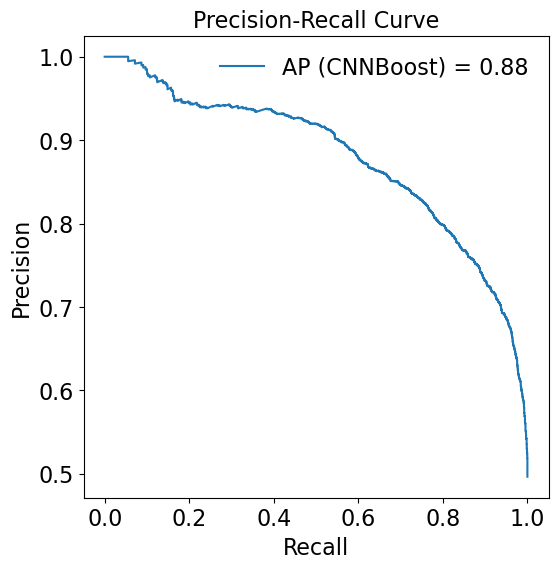

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_CNN, recall_CNN, _ = precision_recall_curve(y_mon_test, y_pred_CNN)
auc_CNN = auc(recall_CNN, precision_CNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_CNN, precision_CNN, label=f'AP (CNNBoost) = {auc_CNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [27]:
auc_CNN

0.8789691590999841

209/209 [==============================] - 3s 14ms/step
Classification score:


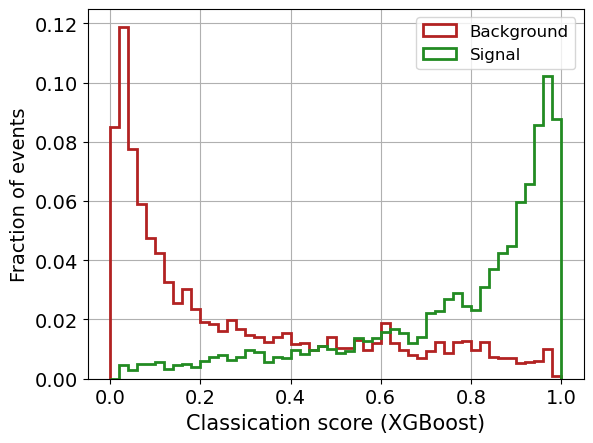

In [22]:
yhat = model.predict(X_mon_test) 

# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_CNN[i,0])
    else:
        pred_XG_NP.append(y_pred_CNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()